# Import

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = '/project/hfa_work/ENCODE/data/SQANTI_reports'

In [3]:
TISSUES = ['aorta', 'colon', 'brain', 'heart', 'lung', 'muscle']
TOOLS = ['flair', 'isoquant', 'isotools_v0', 'isotools_v1', 'isotools_v2', 'isotools_v3', 'stringtie']
TOOLS = ['flair', 'isoquant', 'isotools_v0', 'stringtie']
tissue = 'aorta'
tool = 'isoquant'

In [4]:
max_isotools_suffix = max([int(t.replace('isotools_v', '')) for t in TOOLS if 'isotools_v' in t])
plot_directory = os.path.join('/home/lankenau/Vault/Images/plots/', f'v{max_isotools_suffix}')
plot_directory

'/home/lankenau/Vault/Images/plots/v0'

In [5]:
df = pd.read_csv(os.path.join(path, f'{tissue}_{tool}_classification.txt'), sep='\t')
df.head()

isoform chrom strand  length  exons structural_category  \
0  ENST00000003583.12  chr1      -    2544      8   full-splice_match   
1  ENST00000037502.11  chr1      -    2100      3   full-splice_match   
2   ENST00000040877.2  chr1      -    5206     30   full-splice_match   
3  ENST00000054666.11  chr1      +    2178      5   full-splice_match   
4   ENST00000060969.6  chr1      -    5494      5   full-splice_match   

      associated_gene associated_transcript  ref_length  ref_exons  ...  \
0  ENSG00000001460.18    ENST00000003583.12      2544.0        8.0  ...   
1  ENSG00000034971.17    ENST00000037502.11      2100.0        3.0  ...   
2  ENSG00000059588.10     ENST00000040877.2      5206.0       30.0  ...   
3  ENSG00000049245.13    ENST00000054666.11      2178.0        5.0  ...   
4  ENSG00000052723.12     ENST00000060969.6      5494.0        5.0  ...   

   seq_A_downstream_TTS  dist_to_CAGE_peak  within_CAGE_peak  \
0  TATTGAGCTTTTGGGTACCC               -1.0              True   
1  CGTTCTCTTCCTTGAACTTT             2311.0             False   
2  TTTATTTCCTAGAAACGCCT               -1.0              True   
3  TTGTGGCACCTGTGCTCCTT                0.0              True   
4  TCCTTGCTAATATTTTACTT               14.0             False   

   dist_to_polyA_site within_polyA_site  polyA_motif polyA_dist  \
0               -23.0              True       ATTAAA      -16.0   
1               -14.0              True       AATAAA      -15.0   
2               -10.0              True       AATAAA      -24.0   
3                32.0              True       AATAAA      -17.0   
4               -24.0              True       AATAAA      -21.0   

   polyA_motif_found  ORF_seq    ratio_TSS  
0               True      NaN   201.000000  
1               True      NaN  2751.000000  
2               True      NaN          NaN  
3               True      NaN  2527.237624  
4               True      NaN   801.000000  

[5 rows x 48 columns]

In [6]:
df.columns

Index(['isoform', 'chrom', 'strand', 'length', 'exons', 'structural_category',
       'associated_gene', 'associated_transcript', 'ref_length', 'ref_exons',
       'diff_to_TSS', 'diff_to_TTS', 'diff_to_gene_TSS', 'diff_to_gene_TTS',
       'subcategory', 'RTS_stage', 'all_canonical', 'min_sample_cov',
       'min_cov', 'min_cov_pos', 'sd_cov', 'FL', 'n_indels', 'n_indels_junc',
       'bite', 'iso_exp', 'gene_exp', 'ratio_exp', 'FSM_class', 'coding',
       'ORF_length', 'CDS_length', 'CDS_start', 'CDS_end', 'CDS_genomic_start',
       'CDS_genomic_end', 'predicted_NMD', 'perc_A_downstream_TTS',
       'seq_A_downstream_TTS', 'dist_to_CAGE_peak', 'within_CAGE_peak',
       'dist_to_polyA_site', 'within_polyA_site', 'polyA_motif', 'polyA_dist',
       'polyA_motif_found', 'ORF_seq', 'ratio_TSS'],
      dtype='object')

In [7]:
# speeds up import when reexecuting
classifications = {} if not 'classifications' in globals() else classifications

def get_classification(tissue, tool) -> pd.DataFrame:
    if not tissue in classifications:
        classifications[tissue] = {}
    if not tool in classifications[tissue]:
        classifications[tissue][tool] = pd.read_csv(os.path.join(path, f'{tissue}_{tool}_classification.txt'), sep='\t')
    return classifications[tissue][tool]

In [8]:
all = pd.DataFrame()
for tissue in TISSUES:
    for tool in TOOLS:
        df = get_classification(tissue, tool).copy()
        df.insert(0, 'tissue', tissue)
        if tool == 'isotools_v0' and max_isotools_suffix == 0:
            df.insert(1, 'tool', 'isotools')
        else:
            df.insert(1, 'tool', tool)
        # Rename and make boolean
        df['category'] = df['structural_category']
        df['TSS ratio'] = df['ratio_TSS'] > 1.5
        df['CAGE support'] = df['within_CAGE_peak']
        df['polyA site'] = df['within_polyA_site']
        df['polyA motif'] = df['polyA_motif_found']
        df['start both'] = df['TSS ratio'] & df['CAGE support']
        df['end both'] = df['polyA site'] & df['polyA motif']
        all = pd.concat([all, df], ignore_index=True)

In [9]:
# Rename categories
all['category'] = all['category'].replace({
    'intergenic': 'Intergenic',
    'antisense': 'Antisense',
    'genic': 'Genic',
    'genic_intron': 'Genic Intron',
    'fusion': 'Fusion',
    'full-splice_match': 'FSM',
    'incomplete-splice_match': 'ISM',
    'novel_in_catalog': 'NIC',
    'novel_not_in_catalog': 'NNC'
})

In [10]:
all

tissue       tool             isoform chrom strand  length  exons  \
0         aorta      flair  ENST00000037502.11  chr1      -    2100      3   
1         aorta      flair   ENST00000040877.2  chr1      -    5180     30   
2         aorta      flair  ENST00000054666.11  chr1      +    2178      5   
3         aorta      flair   ENST00000060969.6  chr1      -    1414      5   
4         aorta      flair   ENST00000072644.7  chr1      -    1822     11   
...         ...        ...                 ...   ...    ...     ...    ...   
3061300  muscle  stringtie       MSTRG.25759.2  chrY      +    3708      8   
3061301  muscle  stringtie       MSTRG.25759.3  chrY      +    1205      9   
3061302  muscle  stringtie       MSTRG.25759.4  chrY      +    1322     12   
3061303  muscle  stringtie       MSTRG.25759.5  chrY      +    1976     10   
3061304  muscle  stringtie       MSTRG.25760.1  chrY      -    1108      1   

          structural_category     associated_gene associated_transcript  ...  \
0           full-splice_match  ENSG00000034971.17    ENST00000037502.11  ...   
1           full-splice_match  ENSG00000059588.10     ENST00000040877.2  ...   
2           full-splice_match  ENSG00000049245.13    ENST00000054666.11  ...   
3           full-splice_match  ENSG00000052723.12     ENST00000060969.6  ...   
4           full-splice_match  ENSG00000058799.15     ENST00000072644.7  ...   
...                       ...                 ...                   ...  ...   
3061300      novel_in_catalog   ENSG00000292348.1                 novel  ...   
3061301      novel_in_catalog   ENSG00000292348.1                 novel  ...   
3061302      novel_in_catalog   ENSG00000292348.1                 novel  ...   
3061303  novel_not_in_catalog   ENSG00000292348.1                 novel  ...   
3061304          genic_intron       novelGene_606                 novel  ...   

         polyA_motif_found  ORF_seq    ratio_TSS      category  TSS ratio  \
0                     True      NaN  2751.000000           FSM       True   
1                     True      NaN          NaN           FSM      False   
2                     True      NaN  2527.237624           FSM       True   
3                     True      NaN     7.842750           FSM       True   
4                     True      NaN   255.455446           FSM       True   
...                    ...      ...          ...           ...        ...   
3061300               True      NaN  1051.000000           NIC       True   
3061301               True      NaN  1051.000000           NIC       True   
3061302               True      NaN  1201.000000           NIC       True   
3061303               True      NaN  1201.000000           NNC       True   
3061304               True      NaN     0.980124  Genic Intron      False   

         CAGE support polyA site  polyA motif start both  end both  
0               False       True         True      False      True  
1                True       True         True      False      True  
2                True       True         True       True      True  
3               False       True         True      False      True  
4               False       True         True      False      True  
...               ...        ...          ...        ...       ...  
3061300         False      False         True      False     False  
3061301         False      False         True      False     False  
3061302         False      False         True      False     False  
3061303         False      False         True      False     False  
3061304         False      False         True      False     False  

[3061305 rows x 57 columns]

# Transcript Counts

Barplot for the number of isoforms for each tool and tissue

In [11]:
agg_all = all.groupby(['tool', 'tissue']).agg({'TSS ratio': 'sum', 'CAGE support': 'sum', 'polyA site': 'sum', 'polyA motif': 'sum', 'start both': 'sum', 'end both': 'sum', 'isoform': 'count'}).reset_index()
agg_all['count'] = agg_all['isoform']

agg_by_category = all.groupby(['tool', 'tissue', 'category']).agg({'TSS ratio': 'sum', 'CAGE support': 'sum', 'polyA site': 'sum', 'polyA motif': 'sum', 'start both': 'sum', 'end both': 'sum', 'isoform': 'count'}).reset_index()
agg_by_category['count'] = agg_by_category['isoform']

agg_by_subcategory = all.groupby(['tool', 'tissue', 'category', 'subcategory']).agg({'TSS ratio': 'sum', 'CAGE support': 'sum', 'polyA site': 'sum', 'polyA motif': 'sum', 'start both': 'sum', 'end both': 'sum', 'isoform': 'count'}).reset_index()
agg_by_subcategory['count'] = agg_by_subcategory['isoform']

In [12]:
agg_by_category

tool  tissue      category  TSS ratio  CAGE support  polyA site  \
0        flair   aorta     Antisense        971            31         803   
1        flair   aorta           FSM      14902          9402       18178   
2        flair   aorta        Fusion        211           111         244   
3        flair   aorta         Genic       1143           544        1173   
4        flair   aorta  Genic Intron        612            45        1658   
..         ...     ...           ...        ...           ...         ...   
211  stringtie  muscle  Genic Intron         22             6          32   
212  stringtie  muscle           ISM         19            20          36   
213  stringtie  muscle    Intergenic         51             6          47   
214  stringtie  muscle           NIC       2433          1447        3180   
215  stringtie  muscle           NNC        963           570        1184   

     polyA motif  start both  end both  isoform  count  
0           3647           5       430    13301  13301  
1          17716        7634     16379    21524  21524  
2            248          90       206      365    365  
3           2203         417       772     6161   6161  
4           9307           1       836    33049  33049  
..           ...         ...       ...      ...    ...  
211          108           1        22      416    416  
212           32          10        28       46     46  
213           90           3        39      190    190  
214         3203        1200      2995     3636   3636  
215         1285         445      1117     1488   1488  

[216 rows x 11 columns]

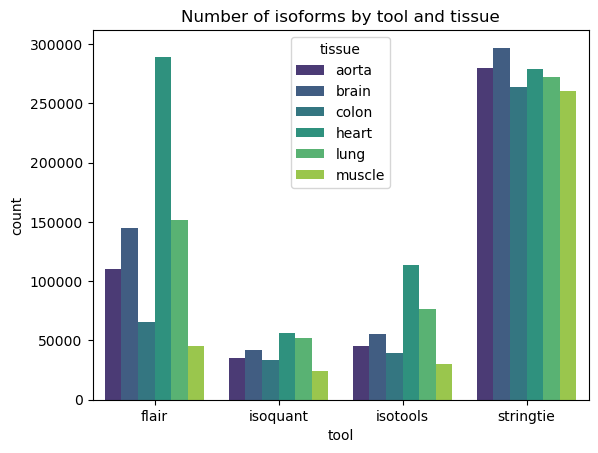

In [13]:
ax1 = sns.barplot(x='tool', y='count', hue='tissue', data=agg_all, palette='viridis')
ax1.set_title('Number of isoforms by tool and tissue')
plt.savefig(os.path.join(plot_directory, 'transcript_counts.png'))

# Category Counts

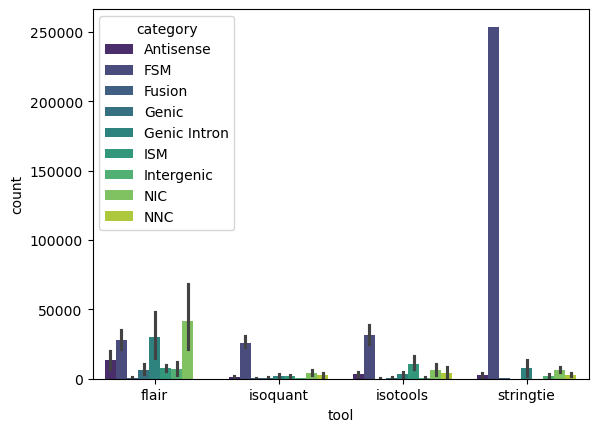

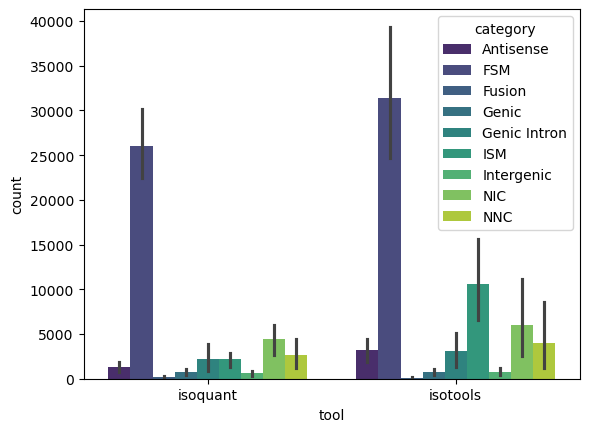

In [14]:
# Counts per category
ax1 = sns.barplot(x='tool', y='count', hue='category', data=agg_by_category, palette='viridis')
plt.show()
ax1 = sns.barplot(x='tool', y='count', hue='category', data=agg_by_category[agg_by_category['tool'].isin(['isoquant', 'isotools', 'isotools_v0', 'isotools_v1', 'isotools_v2', 'isotools_v3'])], palette='viridis')

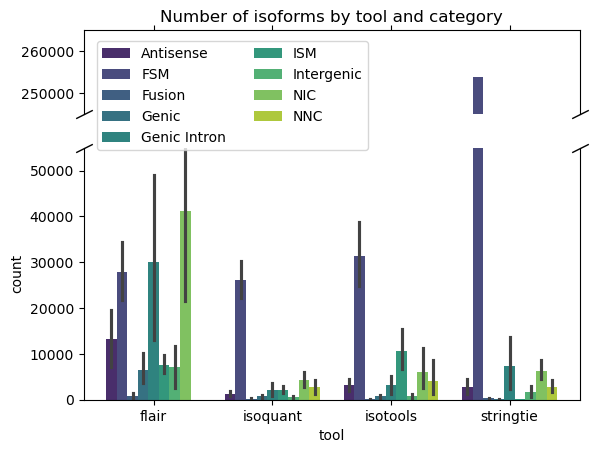

In [15]:
# Based on https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': (1, 3)})
sns.barplot(x='tool', y='count', hue='category', data=agg_by_category, palette='viridis', ax=ax1, legend=False)
ax1.set_title('Number of isoforms by tool and category')
ax1.set_ylabel('')
sns.barplot(x='tool', y='count', hue='category', data=agg_by_category, palette='viridis', ax=ax2)
ax2.legend(loc='upper center', bbox_to_anchor=(0.3, 1.45), ncol=2)

ax1.set_ylim(245_000, 265_000)  # outliers only
ax2.set_ylim(0, 55_000)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.savefig(os.path.join(plot_directory, 'transcript_counts_category.png'))
plt.show()

In [16]:
# Number of FSMs of StringTie in each tissue
agg_by_category[(agg_by_category['tool'] == 'stringtie') & (agg_by_category['category'] == 'FSM')]

tool  tissue category  TSS ratio  CAGE support  polyA site  \
163  stringtie   aorta      FSM      73270         36721      121411   
172  stringtie   brain      FSM      82558         43997      120564   
181  stringtie   colon      FSM      78157         40298      121857   
190  stringtie   heart      FSM      92129         30626      120865   
199  stringtie    lung      FSM      85016         39101      121545   
208  stringtie  muscle      FSM      68739         34979      121646   

     polyA motif  start both  end both  isoform   count  
163       144379       24898     99891   253740  253740  
172       144001       30553     99175   253721  253721  
181       145053       28438    100581   253744  253744  
190       144235       26283     99451   253745  253745  
199       144880       29813    100325   253736  253736  
208       144292       24499    100016   253777  253777

In [17]:
# Mean counts per category
agg_by_category.groupby(['tool', 'category']).agg(count_mean=('count', 'mean')).reset_index()

tool      category     count_mean
0       flair     Antisense   13296.833333
1       flair           FSM   27774.333333
2       flair        Fusion     850.666667
3       flair         Genic    6425.833333
4       flair  Genic Intron   30149.833333
5       flair           ISM    7648.333333
6       flair    Intergenic    7088.166667
7       flair           NIC   41260.666667
8       flair           NNC      11.000000
9    isoquant     Antisense    1357.000000
10   isoquant           FSM   26049.666667
11   isoquant        Fusion     213.166667
12   isoquant         Genic     772.666667
13   isoquant  Genic Intron    2216.500000
14   isoquant           ISM    2185.833333
15   isoquant    Intergenic     590.333333
16   isoquant           NIC    4411.500000
17   isoquant           NNC    2687.500000
18   isotools     Antisense    3187.833333
19   isotools           FSM   31405.833333
20   isotools        Fusion     123.833333
21   isotools         Genic     737.000000
22   isotools  Genic Intron    3121.000000
23   isotools           ISM   10632.666667
24   isotools    Intergenic     789.833333
25   isotools           NIC    6057.833333
26   isotools           NNC    4015.833333
27  stringtie     Antisense    2804.166667
28  stringtie           FSM  253743.833333
29  stringtie        Fusion     287.833333
30  stringtie         Genic      66.666667
31  stringtie  Genic Intron    7435.000000
32  stringtie           ISM     106.833333
33  stringtie    Intergenic    1615.500000
34  stringtie           NIC    6357.500000
35  stringtie           NNC    2738.666667

## Subcategory counts

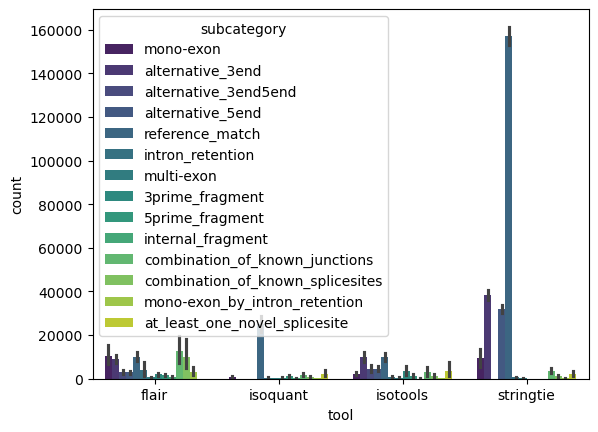

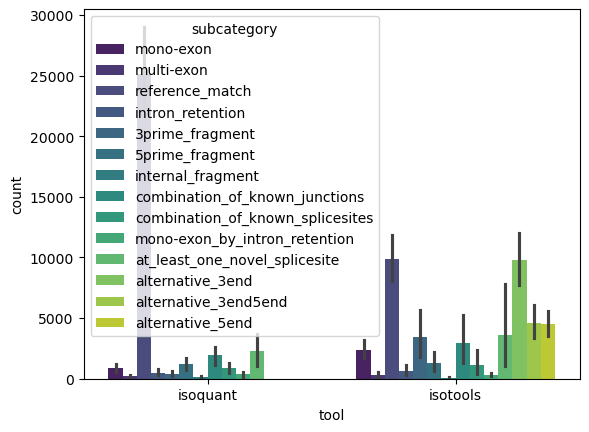

In [18]:
# Counts per subcategory
ax1 = sns.barplot(x='tool', y='count', hue='subcategory', data=agg_by_subcategory, palette='viridis')
plt.show()
ax1 = sns.barplot(x='tool', y='count', hue='subcategory', data=agg_by_subcategory[agg_by_subcategory['tool'].isin(['isoquant', 'isotools', 'isotools_v0', 'isotools_v1', 'isotools_v2', 'isotools_v3'])], palette='viridis')

## ISM subcategory counts

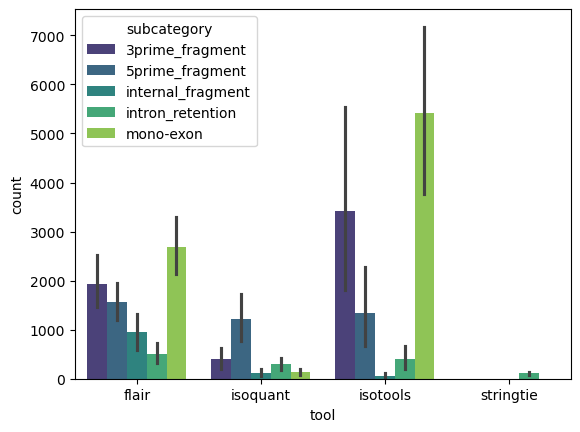

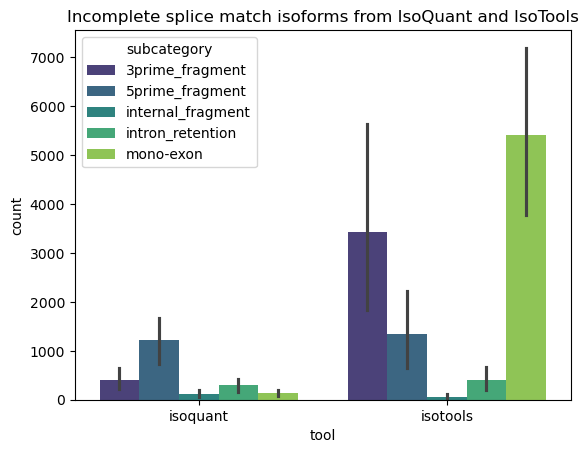

In [19]:
df = agg_by_subcategory.loc[agg_by_subcategory['category'] == 'ISM']
# Counts per subcategory
ax1 = sns.barplot(x='tool', y='count', hue='subcategory', data=df, palette='viridis')
plt.show()
ax1 = sns.barplot(x='tool', y='count', hue='subcategory', data=df[df['tool'].isin(['isoquant', 'isotools', 'isotools_v0', 'isotools_v1', 'isotools_v2', 'isotools_v3'])], palette='viridis')
ax1.set_title('Incomplete splice match isoforms from IsoQuant and IsoTools')
plt.savefig(os.path.join(plot_directory, 'transcript_counts_ISM_isoquant_isotools.png'))

# All

In [20]:
def heatmap(df: pd.DataFrame, column, header_suffix='', export_name=None, **params):
    df = df.copy()
    df.loc[:,'relative_metric'] = df[column] / df['count']
    df.loc[:,'annotation'] = df['relative_metric'].map('{:,.1%}'.format) + \
                            '\n(' + df[column].astype(str) + '/' + df['count'].astype(str) + ')'
    # Reshape the data using pivot
    heatmap_data = df.pivot(index='tool', columns='tissue', values='relative_metric')

    # Annotate each cell with the numeric value and the count
    annot = df.pivot(index='tool', columns='tissue', values='annotation')

    # Plot the heatmap
    plt.figure(figsize=(12, 1 + len(df['tool'].unique())))
    sns.heatmap(heatmap_data, vmin=0, vmax=1, annot=annot, fmt='', linewidths=0.5, **params)
    plt.title(f'Heatmap of {column}{header_suffix}')
    plt.xlabel('Tissue')
    plt.ylabel('Tool')
    if export_name:
        plt.savefig(os.path.join(plot_directory, f'{export_name}.png'), bbox_inches='tight')
    plt.show()

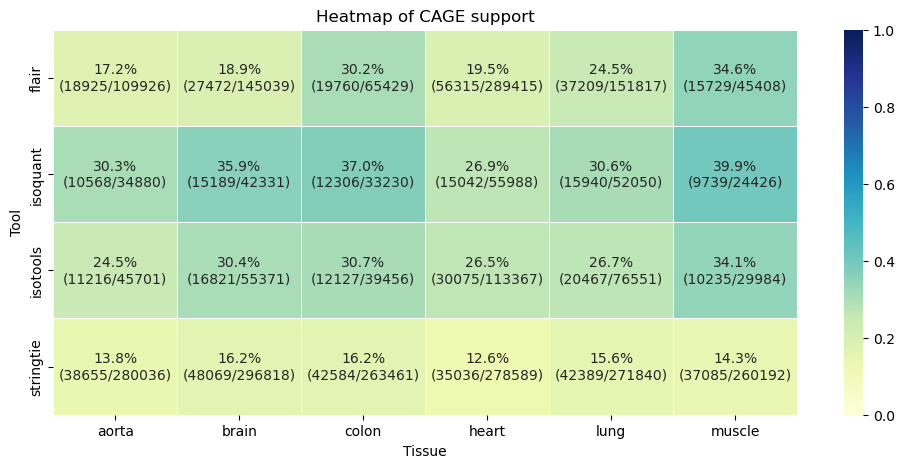

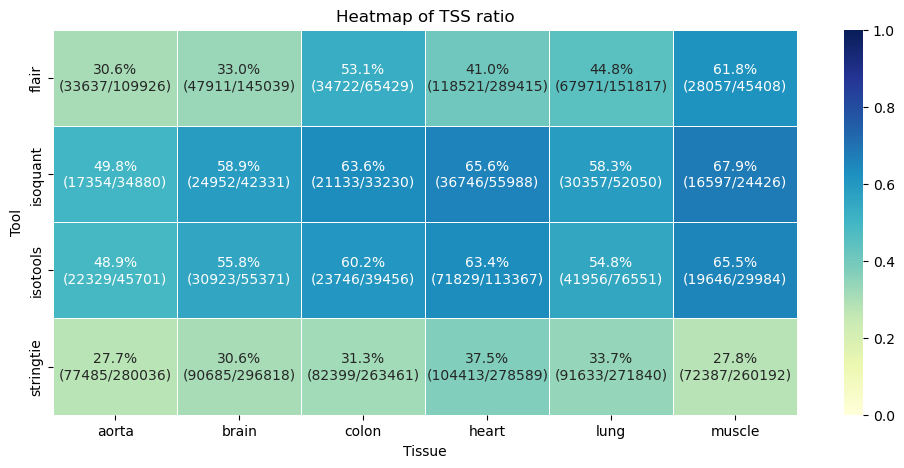

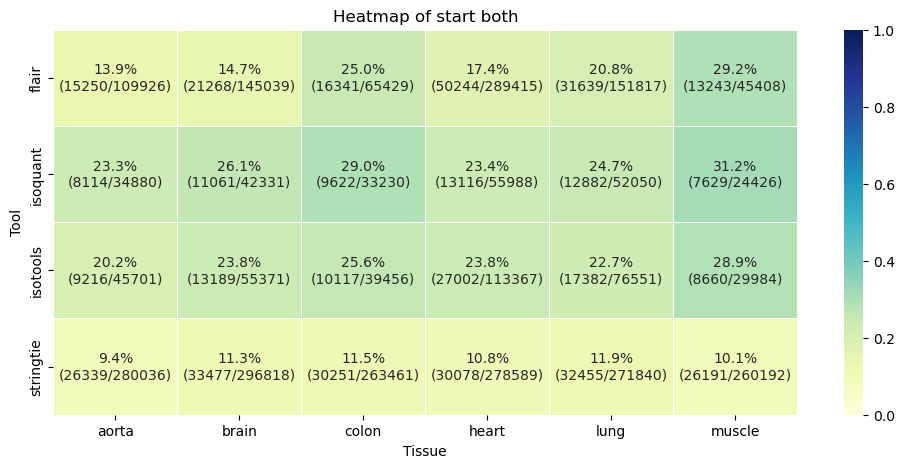

In [21]:
heatmap(agg_all, 'CAGE support', export_name='CAGE_support', cmap='YlGnBu')
heatmap(agg_all, 'TSS ratio', export_name='TSS_ratio', cmap='YlGnBu')
heatmap(agg_all, 'start both', cmap='YlGnBu')

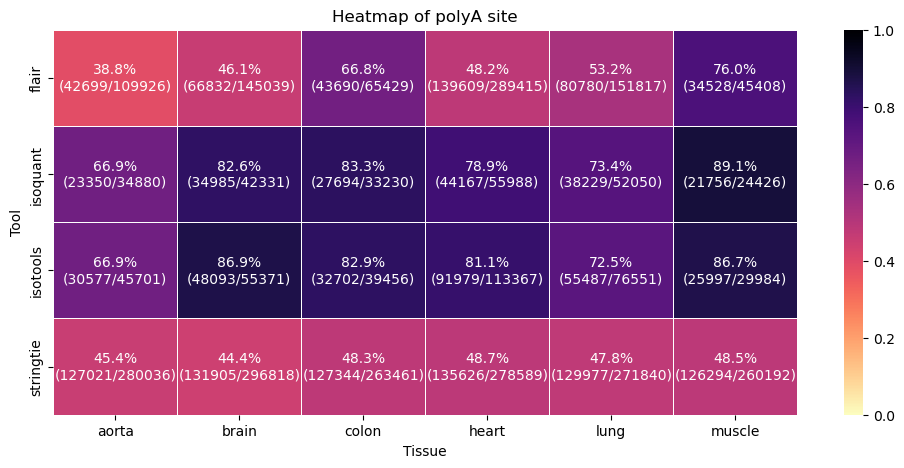

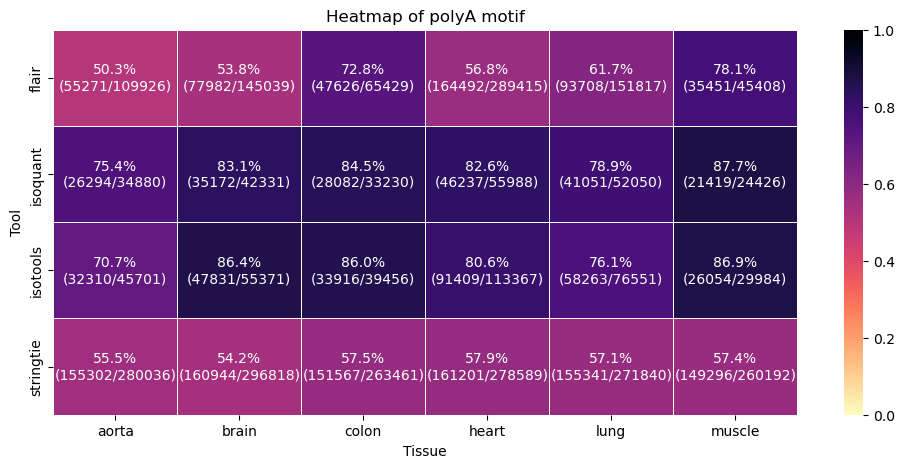

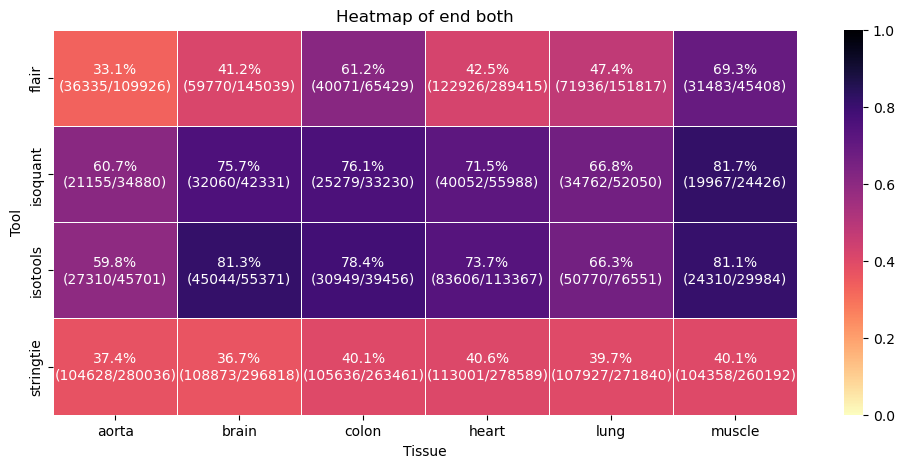

In [22]:
heatmap(agg_all, 'polyA site', export_name='PolyA_site', cmap='magma_r')
heatmap(agg_all, 'polyA motif', export_name='PolyA_motif', cmap='magma_r')
heatmap(agg_all, 'end both', cmap='magma_r')

# By Category

In [23]:
non_fsm_df = agg_by_category.loc[agg_by_category['category'] != 'FSM'].groupby(['tissue', 'tool']).sum().reset_index()

## Starts

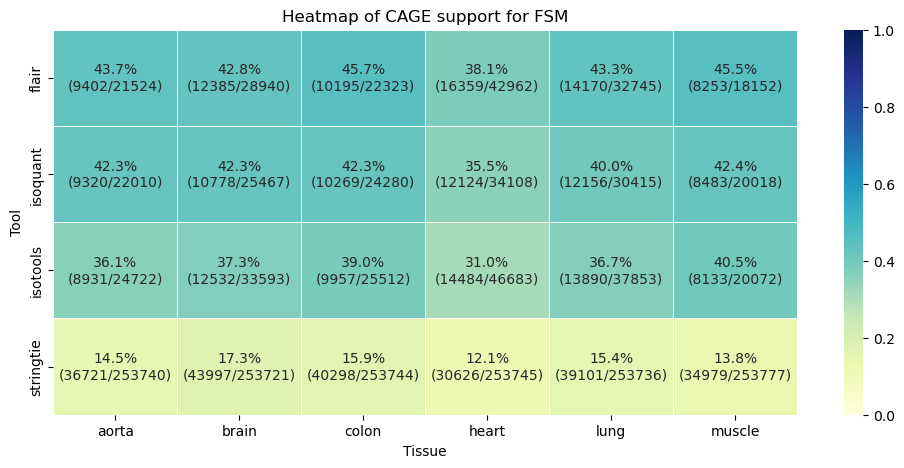

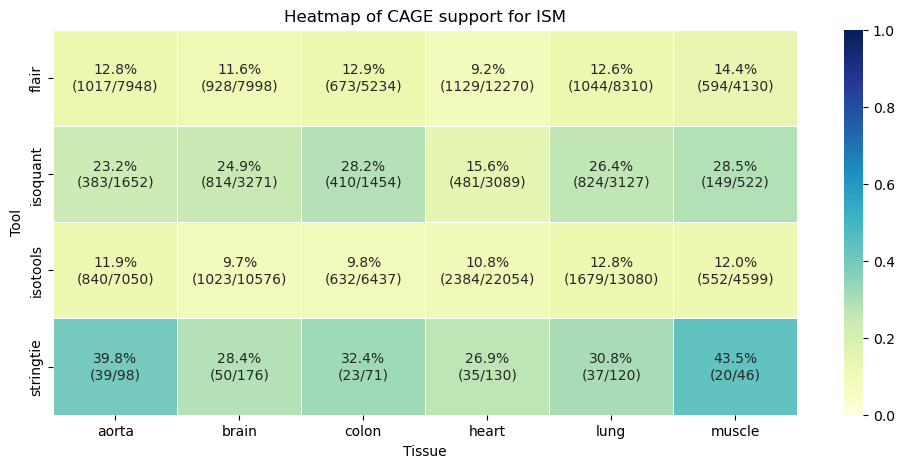

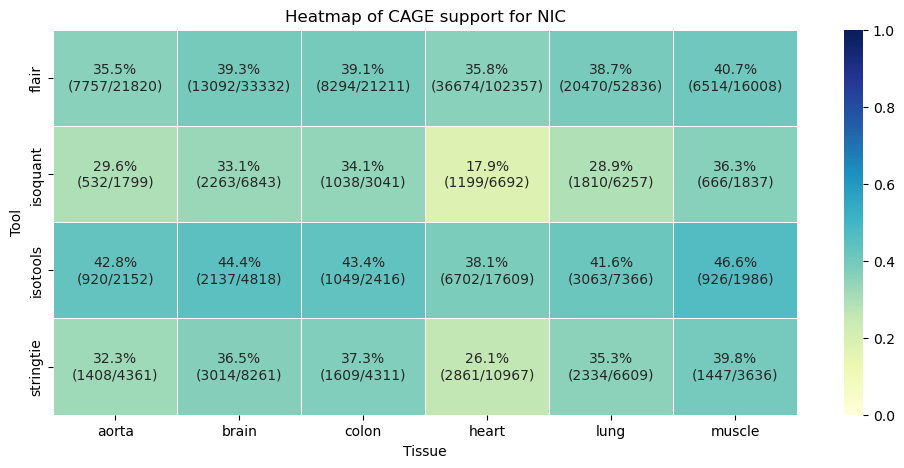

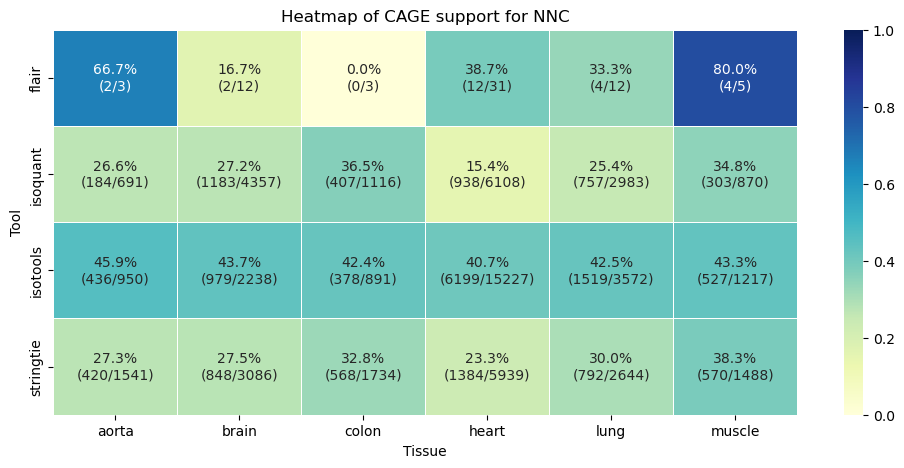

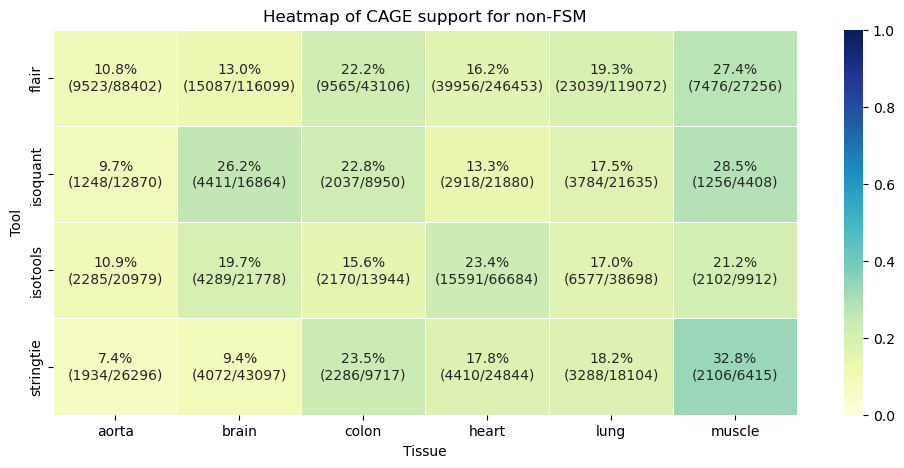

In [24]:
heatmap(agg_by_category.loc[agg_by_category['category'] == 'FSM'], 'CAGE support', ' for FSM', export_name='CAGE_support_FSM', cmap='YlGnBu')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'ISM'], 'CAGE support', ' for ISM', export_name='CAGE_support_ISM', cmap='YlGnBu')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'NIC'], 'CAGE support', ' for NIC', export_name='CAGE_support_NIC', cmap='YlGnBu')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'NNC'], 'CAGE support', ' for NNC', export_name='CAGE_support_NNC', cmap='YlGnBu')
heatmap(non_fsm_df, 'CAGE support', ' for non-FSM', export_name='CAGE_support_non_FSM', cmap='YlGnBu')

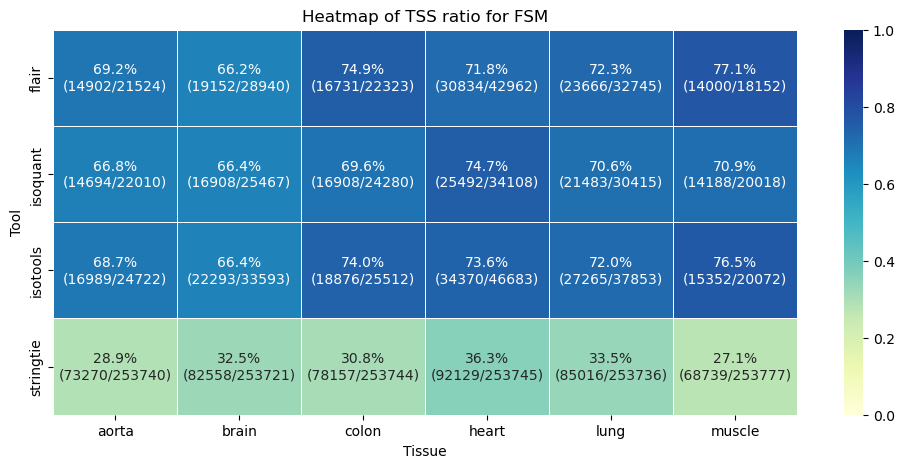

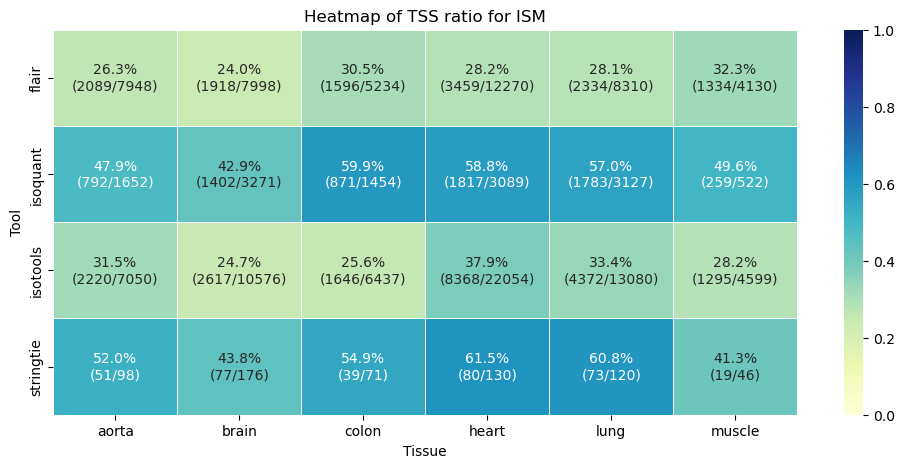

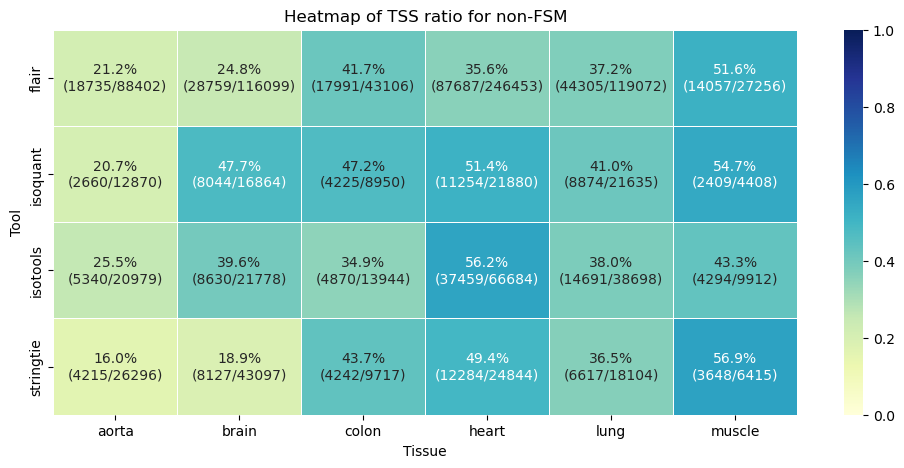

In [25]:
heatmap(agg_by_category.loc[agg_by_category['category'] == 'FSM'], 'TSS ratio', ' for FSM', cmap='YlGnBu')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'ISM'], 'TSS ratio', ' for ISM', cmap='YlGnBu')
heatmap(non_fsm_df, 'TSS ratio', ' for non-FSM', cmap='YlGnBu')

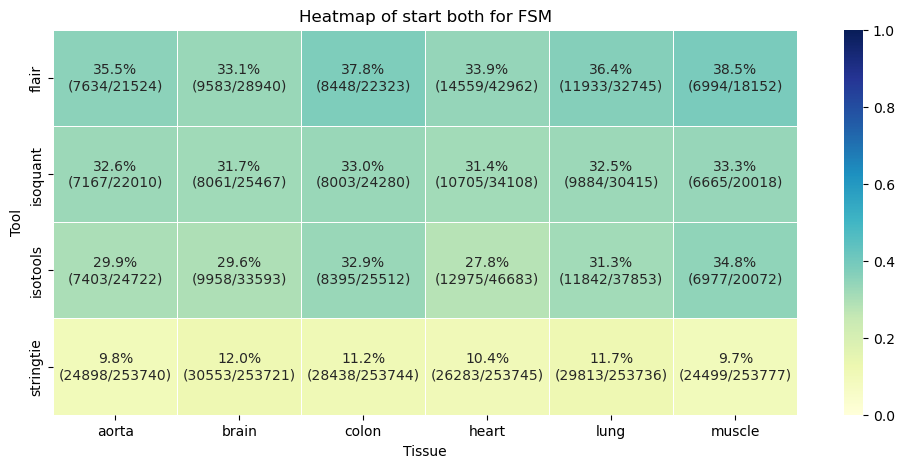

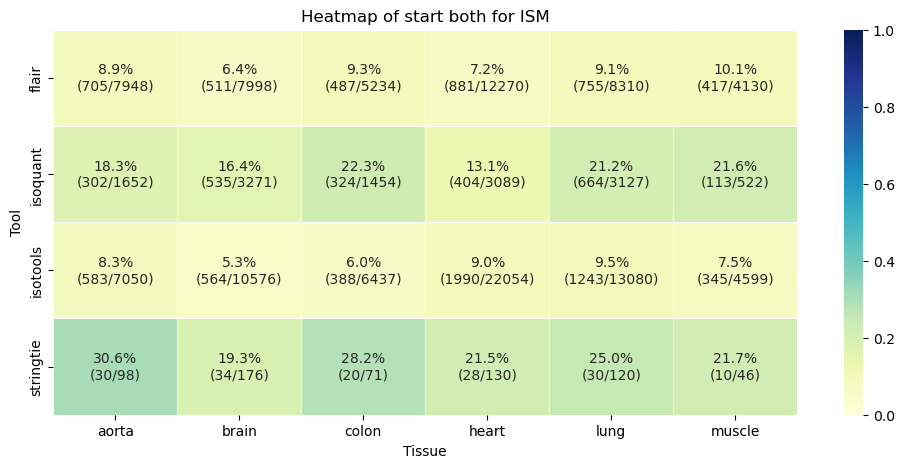

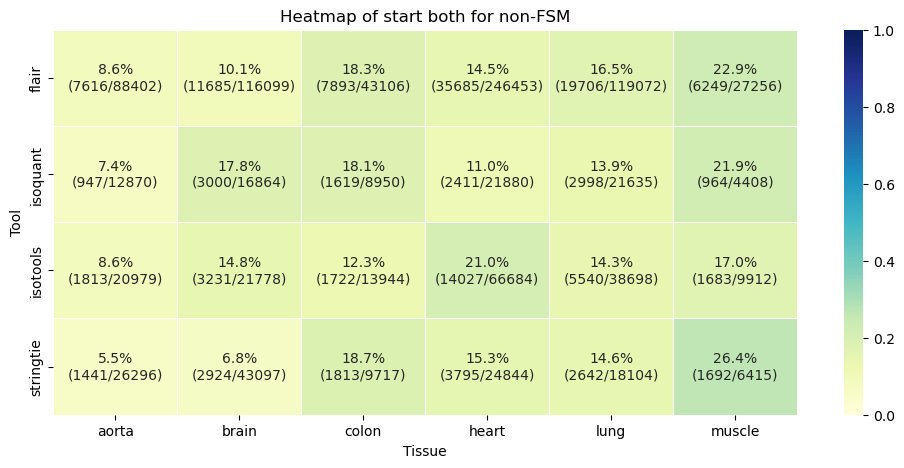

In [26]:
heatmap(agg_by_category.loc[agg_by_category['category'] == 'FSM'], 'start both', ' for FSM', cmap='YlGnBu')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'ISM'], 'start both', ' for ISM', cmap='YlGnBu')
heatmap(non_fsm_df, 'start both', ' for non-FSM', cmap='YlGnBu')

## Ends

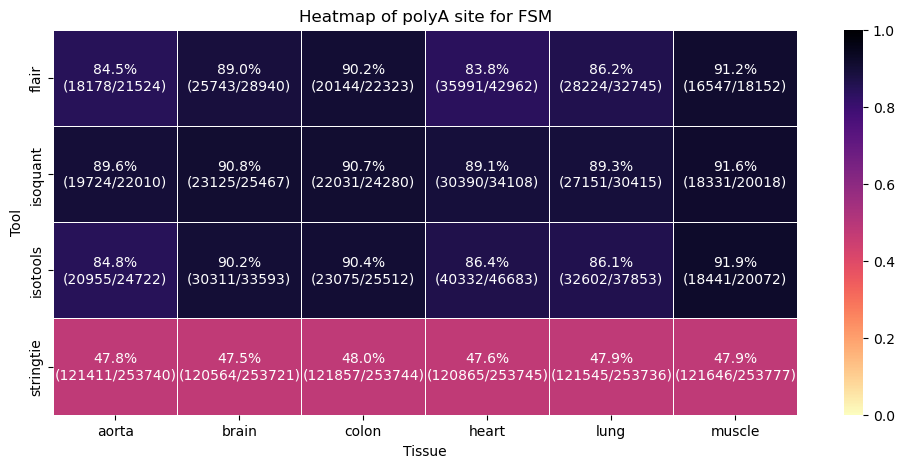

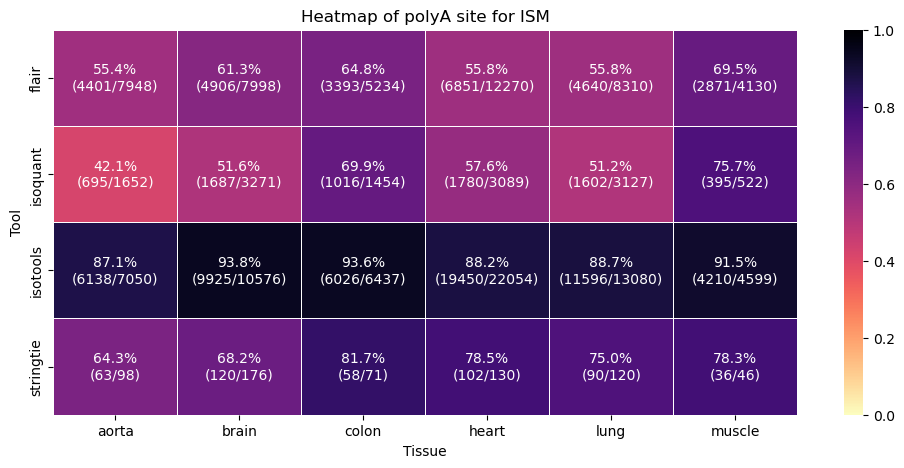

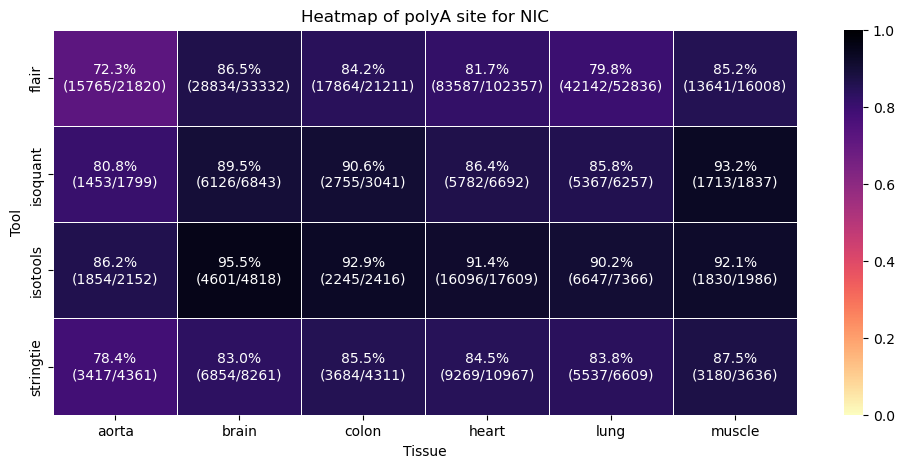

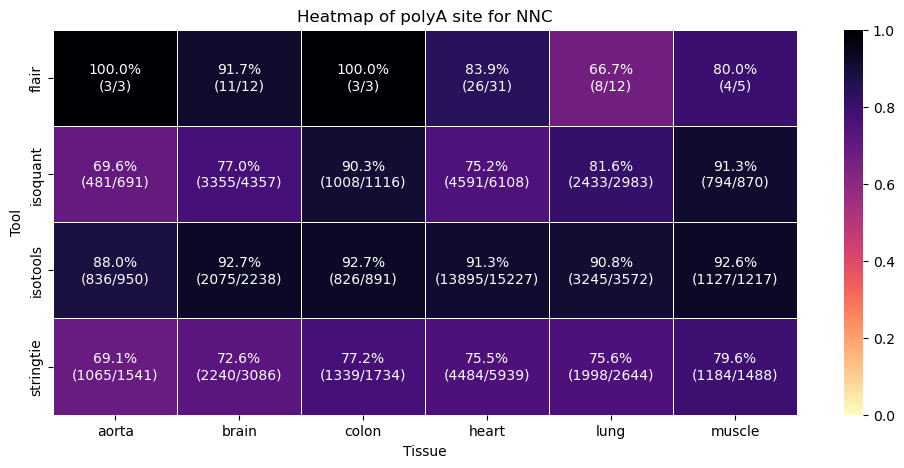

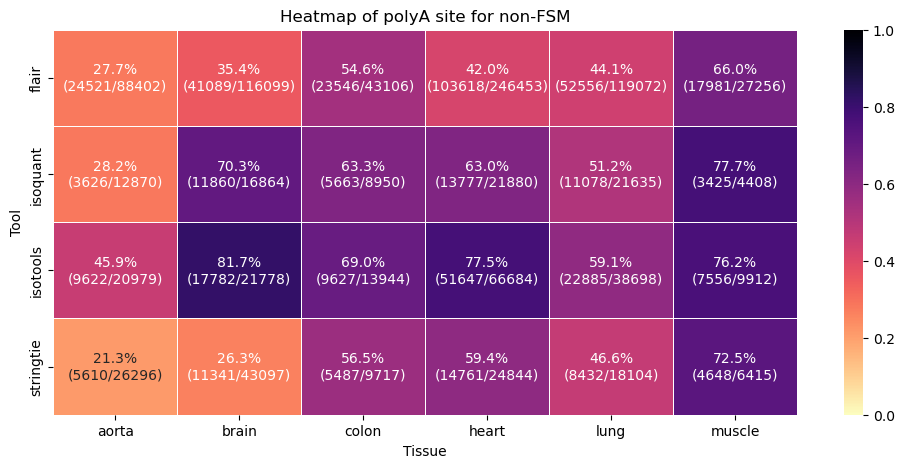

In [27]:
heatmap(agg_by_category.loc[agg_by_category['category'] == 'FSM'], 'polyA site', ' for FSM', export_name="polyA_site_FSM", cmap='magma_r')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'ISM'], 'polyA site', ' for ISM', export_name="polyA_site_ISM", cmap='magma_r')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'NIC'], 'polyA site', ' for NIC', export_name="polyA_site_NIC", cmap='magma_r')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'NNC'], 'polyA site', ' for NNC', export_name="polyA_site_NNC", cmap='magma_r')
heatmap(non_fsm_df, 'polyA site', ' for non-FSM', cmap='magma_r')

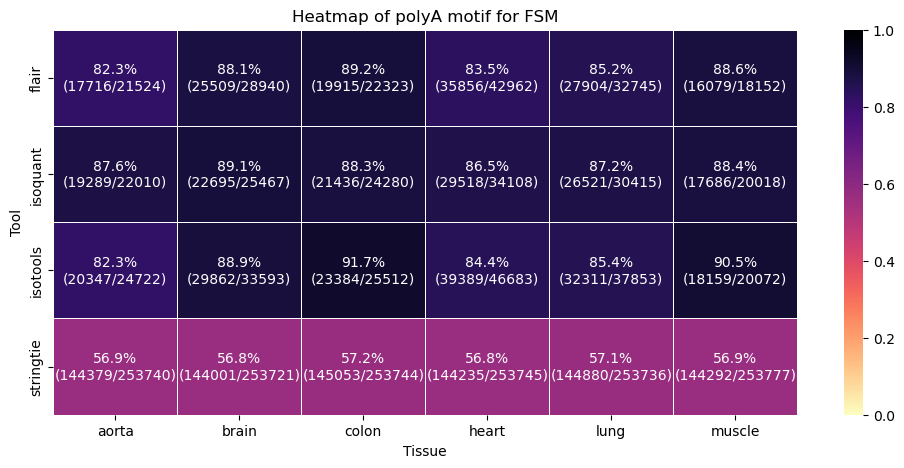

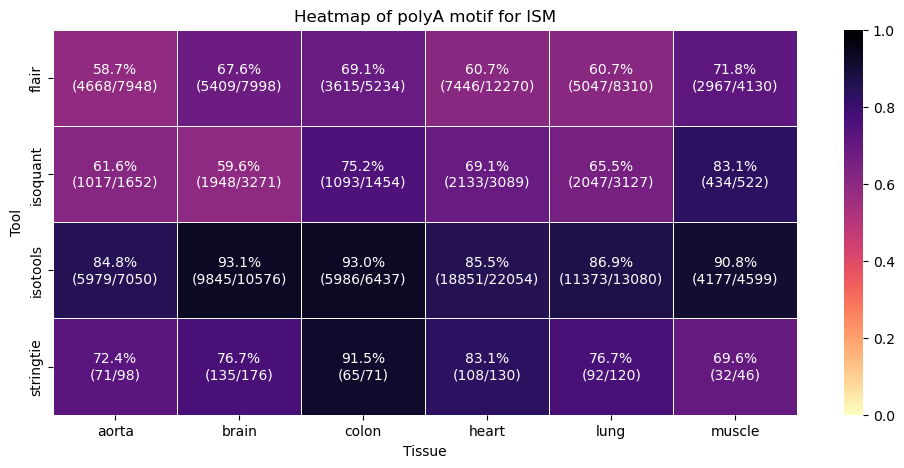

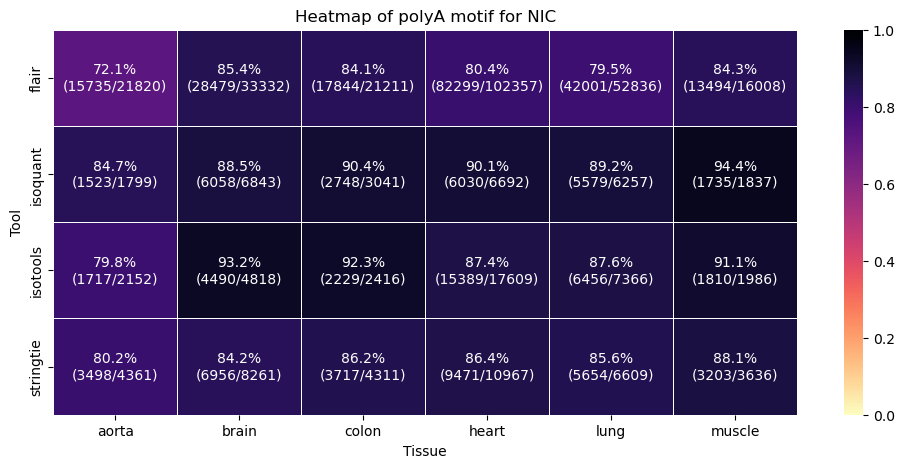

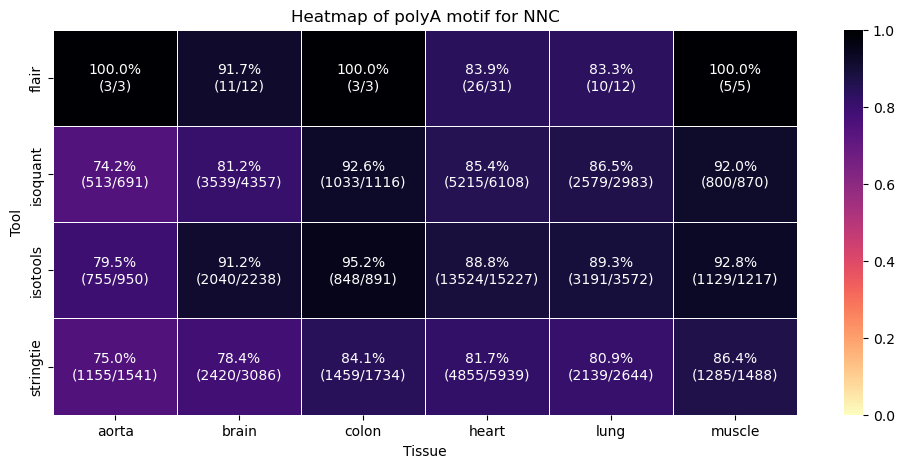

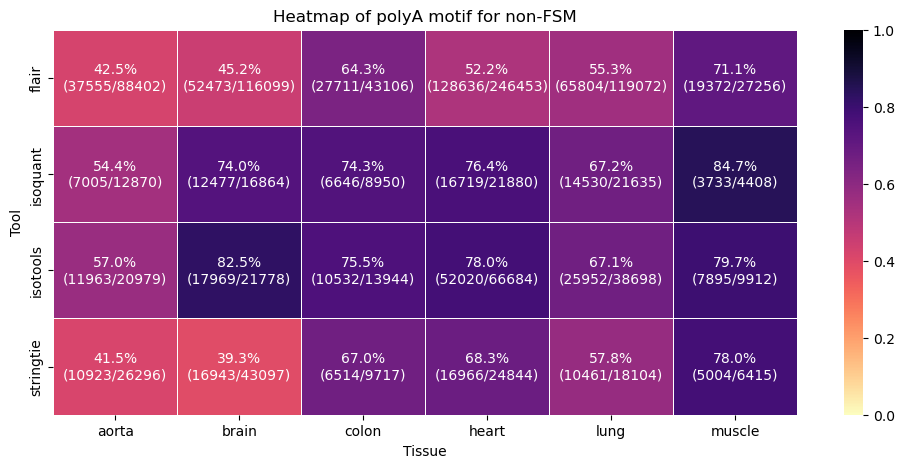

In [28]:
heatmap(agg_by_category.loc[agg_by_category['category'] == 'FSM'], 'polyA motif', ' for FSM', export_name="polyA_motif_FSM", cmap='magma_r')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'ISM'], 'polyA motif', ' for ISM', export_name="polyA_motif_ISM", cmap='magma_r')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'NIC'], 'polyA motif', ' for NIC', export_name="polyA_motif_NIC", cmap='magma_r')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'NNC'], 'polyA motif', ' for NNC', export_name="polyA_motif_NNC", cmap='magma_r')
heatmap(non_fsm_df, 'polyA motif', ' for non-FSM', cmap='magma_r')

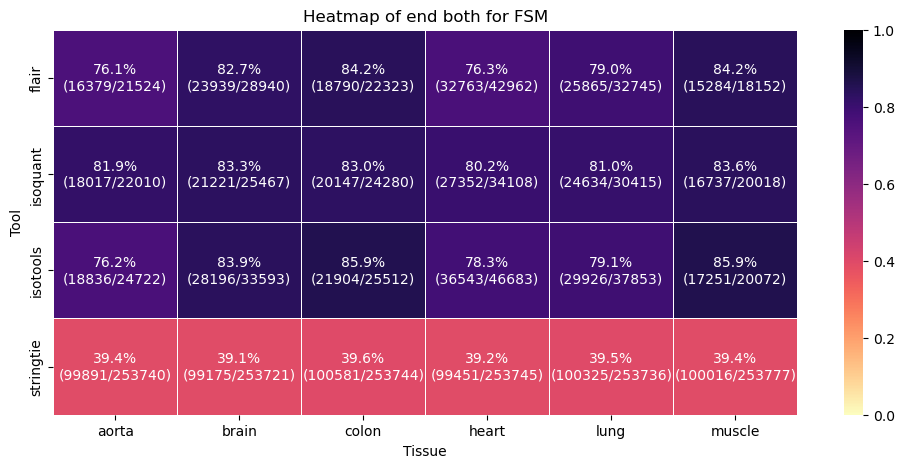

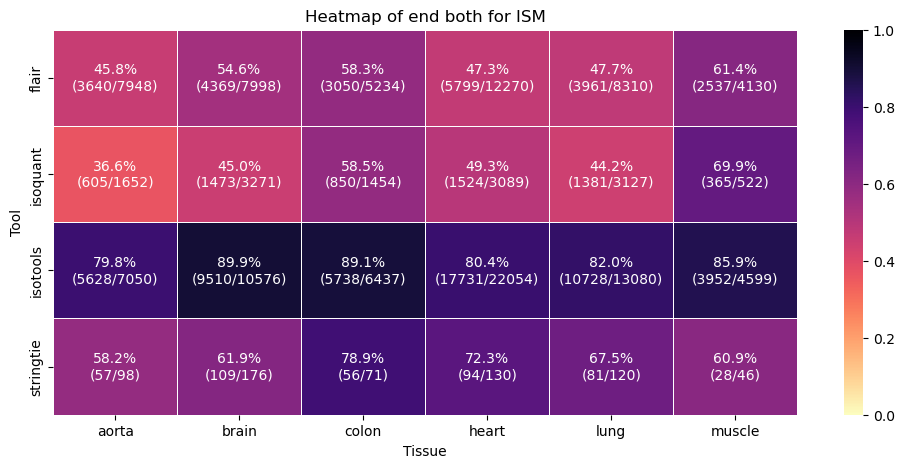

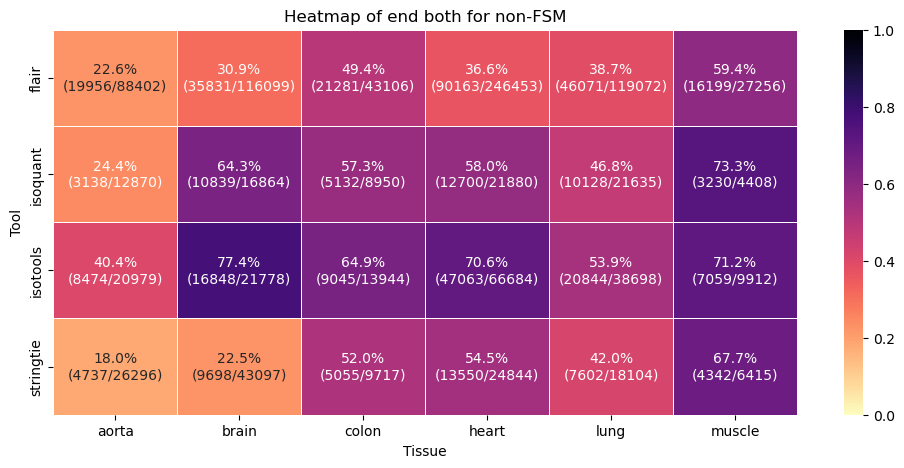

In [29]:
heatmap(agg_by_category.loc[agg_by_category['category'] == 'FSM'], 'end both', ' for FSM', cmap='magma_r')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'ISM'], 'end both', ' for ISM', cmap='magma_r')
heatmap(non_fsm_df, 'end both', ' for non-FSM', cmap='magma_r')

# Subcategory

## Only Monoexons

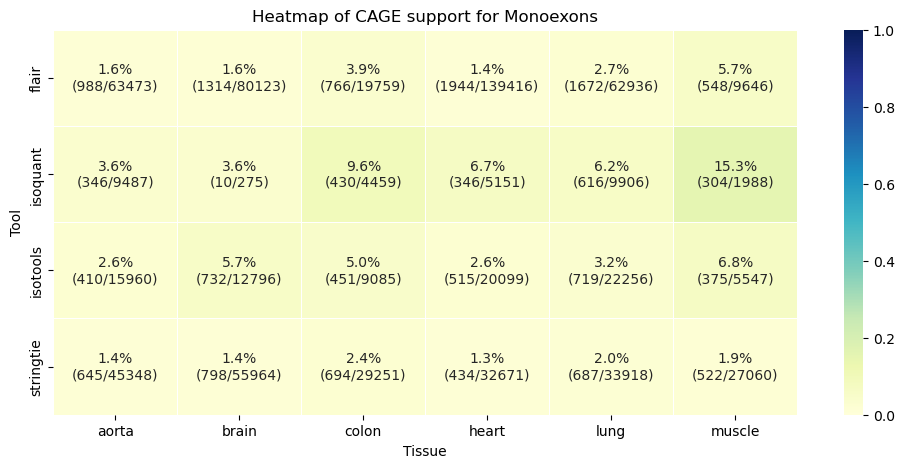

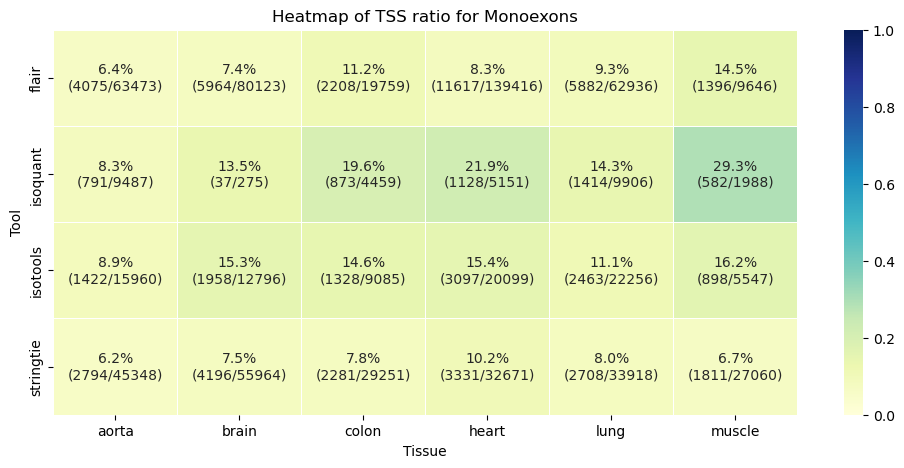

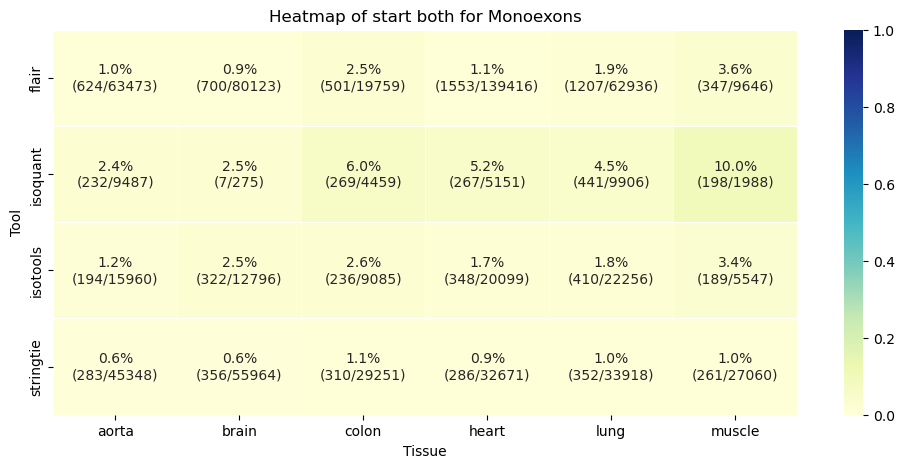

In [30]:
mono_exons = agg_by_subcategory.loc[agg_by_subcategory['subcategory'] == 'mono-exon'].groupby(['tissue', 'tool']).sum().reset_index()
heatmap(mono_exons, 'CAGE support', ' for Monoexons', export_name='CAGE_support_monoexons', cmap='YlGnBu')
heatmap(mono_exons, 'TSS ratio', ' for Monoexons', cmap='YlGnBu')
heatmap(mono_exons, 'start both', ' for Monoexons', cmap='YlGnBu')

## ISM w/o Monoexons

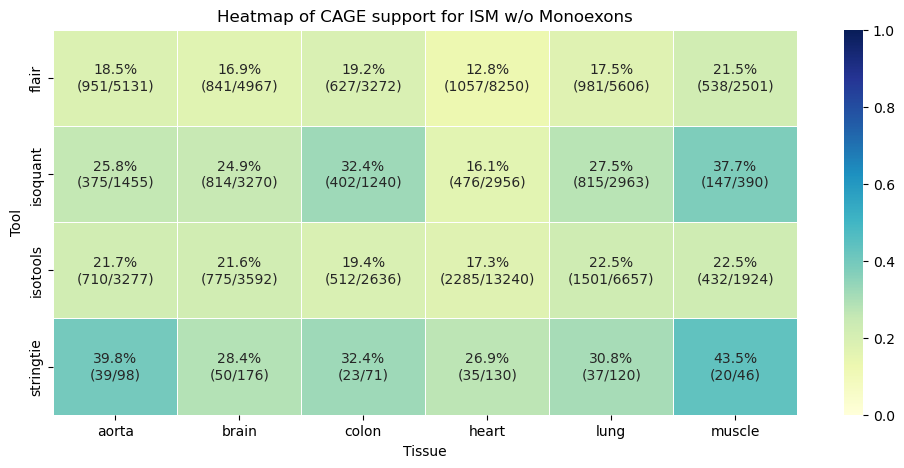

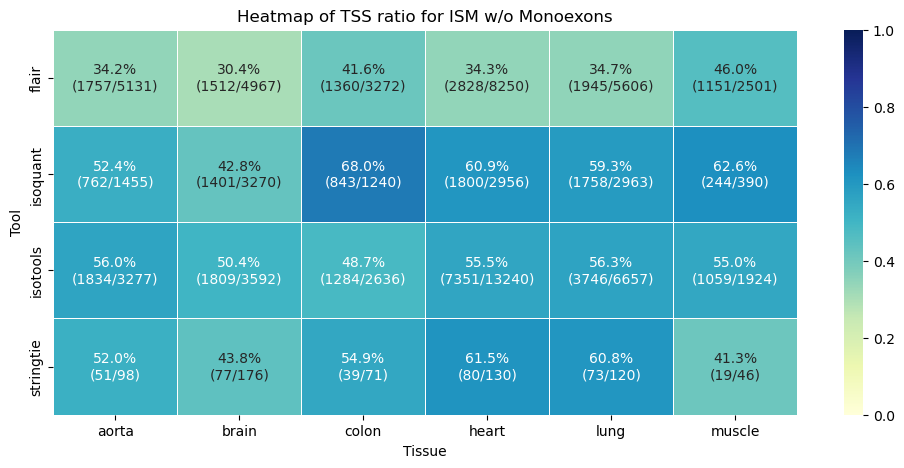

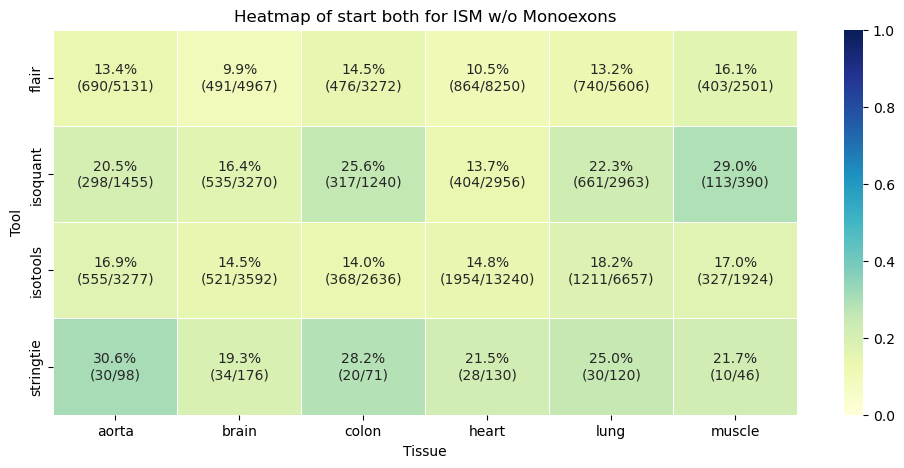

In [31]:
no_mono_ISM = agg_by_subcategory.loc[(agg_by_subcategory['subcategory'] != 'mono-exon') & (agg_by_subcategory['category'] == 'ISM')].groupby(['tissue', 'tool']).sum().reset_index()
heatmap(no_mono_ISM, 'CAGE support', ' for ISM w/o Monoexons', export_name='CAGE_support_ISM_no_monoexons', cmap='YlGnBu')
heatmap(no_mono_ISM, 'TSS ratio', ' for ISM w/o Monoexons', cmap='YlGnBu')
heatmap(no_mono_ISM, 'start both', ' for ISM w/o Monoexons', cmap='YlGnBu')

# All w/o Monoexons

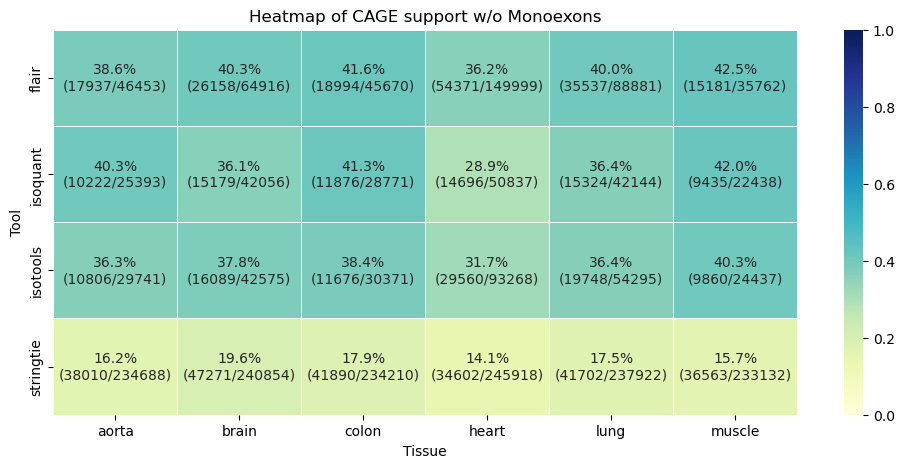

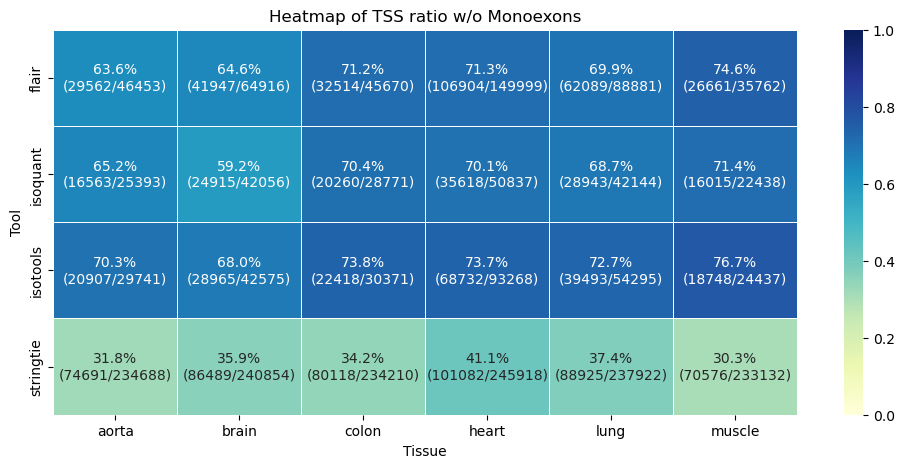

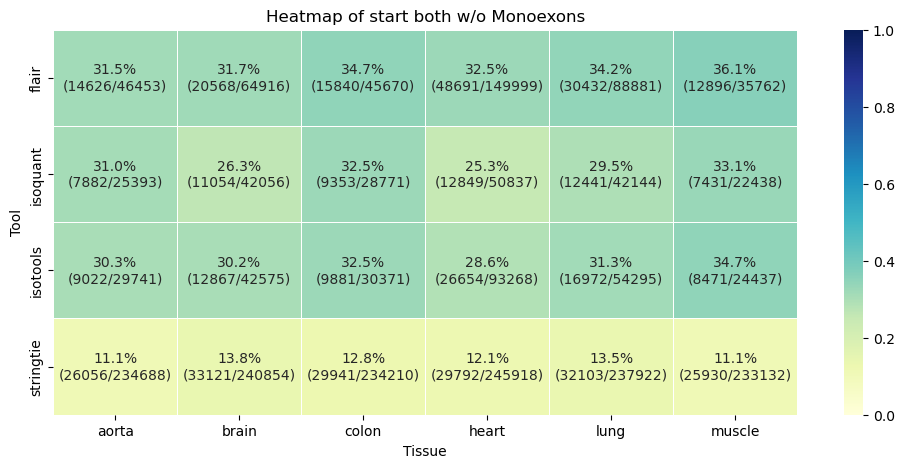

In [32]:
no_mono_all = agg_by_subcategory.loc[(agg_by_subcategory['subcategory'] != 'mono-exon')].groupby(['tissue', 'tool']).sum().reset_index()
heatmap(no_mono_all, 'CAGE support', ' w/o Monoexons', export_name='CAGE_support_no_monoexons', cmap='YlGnBu')
heatmap(no_mono_all, 'TSS ratio', ' w/o Monoexons', cmap='YlGnBu')
heatmap(no_mono_all, 'start both', ' w/o Monoexons', cmap='YlGnBu')

# No monoexons and 3' fragments

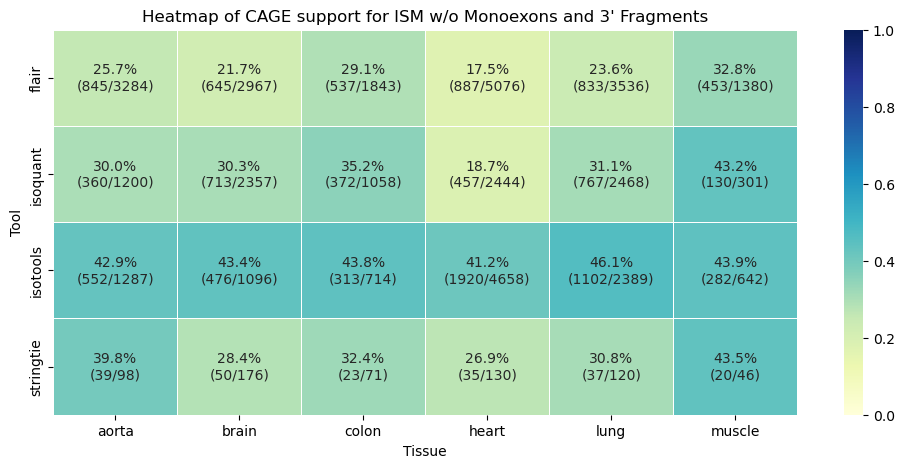

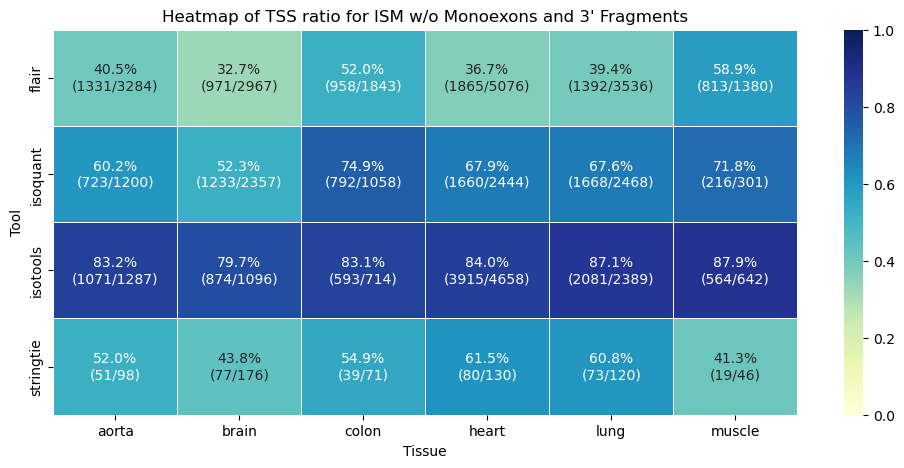

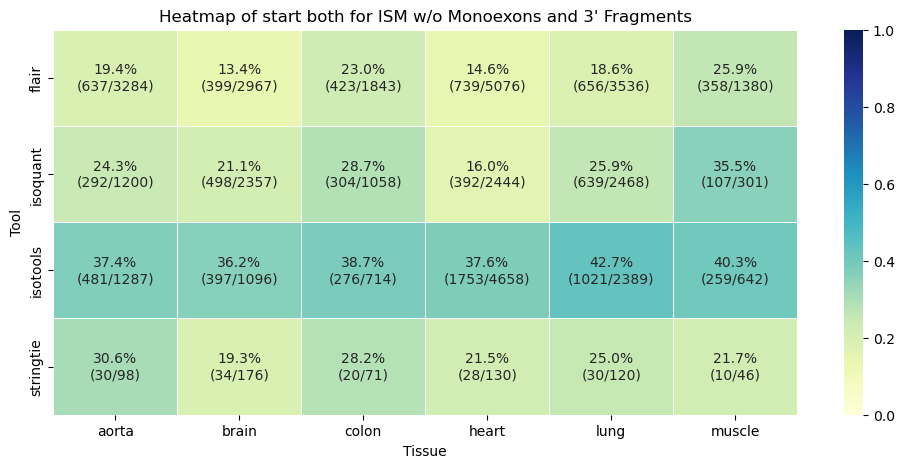

In [33]:
no_mono_3_prime_ISM = agg_by_subcategory.loc[(agg_by_subcategory['subcategory'] != 'mono-exon') &(agg_by_subcategory['subcategory'] != '3prime_fragment') & (agg_by_subcategory['category'] == 'ISM')].groupby(['tissue', 'tool']).sum().reset_index()
heatmap(no_mono_3_prime_ISM, 'CAGE support', ' for ISM w/o Monoexons and 3\' Fragments', export_name='CAGE_support_ISM_no_monoexons', cmap='YlGnBu')
heatmap(no_mono_3_prime_ISM, 'TSS ratio', ' for ISM w/o Monoexons and 3\' Fragments', cmap='YlGnBu')
heatmap(no_mono_3_prime_ISM, 'start both', ' for ISM w/o Monoexons and 3\' Fragments', cmap='YlGnBu')

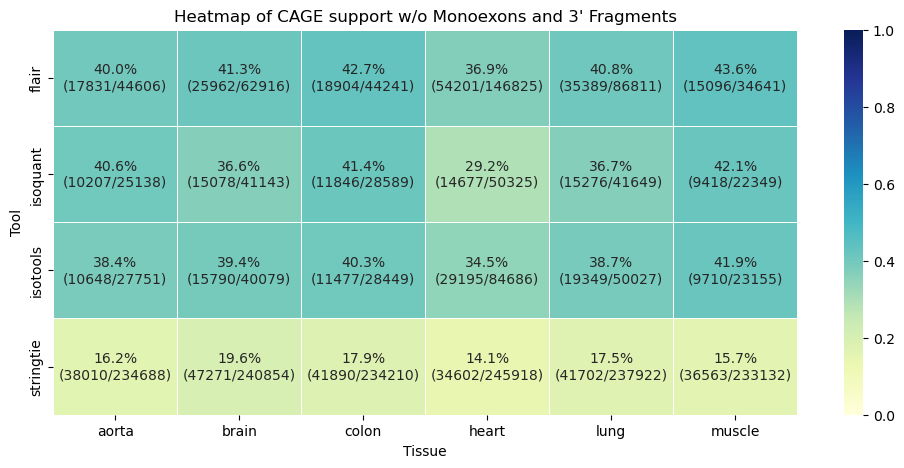

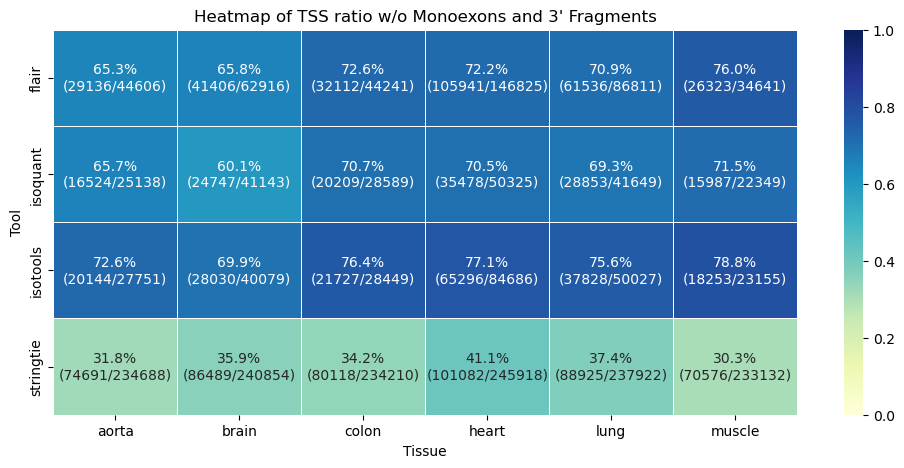

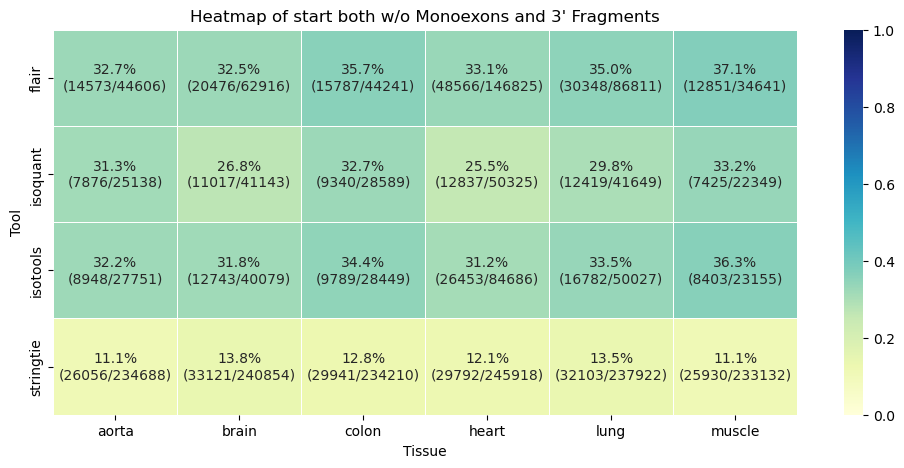

In [34]:
no_mono_3_prime_all = agg_by_subcategory.loc[(agg_by_subcategory['subcategory'] != 'mono-exon') & (agg_by_subcategory['subcategory'] != '3prime_fragment')].groupby(['tissue', 'tool']).sum().reset_index()
heatmap(no_mono_3_prime_all, 'CAGE support', ' w/o Monoexons and 3\' Fragments', export_name='CAGE_support_ISM_no_monoexons', cmap='YlGnBu')
heatmap(no_mono_3_prime_all, 'TSS ratio', ' w/o Monoexons and 3\' Fragments', cmap='YlGnBu')
heatmap(no_mono_3_prime_all, 'start both', ' w/o Monoexons and 3\' Fragments', cmap='YlGnBu')

# Correlation

In [35]:
from scipy.stats import pearsonr

def correlation(df: pd.DataFrame, column1, column2):
    df = df.copy()
    df = df.loc[df['count'] > 0]
    # Calculate the correlation
    corr, p = pearsonr(df[column1], df[column2])
    print(f'Correlation between {column1} and {column2}: {corr:.3f} (p={p:.2e})')

correlation(agg_all, 'CAGE support', 'TSS ratio')
correlation(agg_all, 'polyA motif', 'polyA site')

Correlation between CAGE support and TSS ratio: 0.963 (p=4.65e-14)
Correlation between polyA motif and polyA site: 0.997 (p=1.60e-25)
